**This notebook contains the implementation of a Free-Form Deformation based image transformation.**

The symptoms of skin cancer that appear on the skin surface are characterized by free-form discolorations, and therefore, unlike many other machine vision tasks, non-affine, free-form deformations can be easily and effectively utilized for data augmentation purposes here. This notebook contains such a solution. Its integration into the pipeline will depend on the extent of the positive effect achieved during training.

Note that care must be taken when using this transformation, because one of the core characteristics of melanoma is asymmetricity and currently it can generate (with low probability) symmetric marks from assymetric ones, but this effect is likely negligible.

In [19]:
!pip install matplotlib Pillow

Load *potyok/isic2024/additional_data/test_im_1.jpg* and *potyok/isic2024/additional_data/conc_circles.png* into /content

In [21]:
import numpy as np
import cv2
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

import random

In [22]:
def free_form_deform(image, grid_points, target_points):
    # Free-Form Deformation-based image deformation
    #
    # Params
    # image: the deformable image
    # grid_points: the original grid defined on the image
    # target_points: the original grid's transformed position
    # Return
    # the transformed image

    h, w = image.shape[:2]

    x = np.linspace(0, w-1, w)
    y = np.linspace(0, h-1, h)
    grid_x, grid_y = np.meshgrid(x, y)

    grid_x_flat = grid_x.flatten()
    grid_y_flat = grid_y.flatten()

    original_points = np.column_stack((grid_x_flat, grid_y_flat))

    deformed_points = griddata(grid_points, target_points, original_points, method='linear')

    deformed_x = deformed_points[:, 0].reshape(h, w)
    deformed_y = deformed_points[:, 1].reshape(h, w)

    deformed_image = cv2.remap(image, deformed_x.astype(np.float32), deformed_y.astype(np.float32), interpolation=cv2.INTER_LINEAR)

    return deformed_image

In [23]:
def gen_grid_points(image, grid_size):
    # Generates an evenly distributed grid on the image with the given grid_size
    result = np.zeros((grid_size * grid_size, 2), dtype=int)
    for i in range(grid_size):
        for j in range(grid_size):
            result[i * grid_size + j] = [(i / (grid_size - 1)) * image.shape[1], (j / (grid_size - 1)) * image.shape[0]]
    return result

In [24]:
def gen_target_points(grid, alpha):
    # Generates a random transformed grid from the input grid with
    # alphas close to zero generally result in a smaller displacement of the grid
    grid_size = int(np.sqrt(grid.shape[0]))
    modified_grid = np.zeros((grid_size * grid_size, 2), dtype=int)

    for i in range(grid_size):
        for j in range(grid_size):
            index = i * grid_size + j
            val = grid[index].copy()
            if i != 0 and i != grid_size - 1 and j != 0 and j != grid_size - 1:

                max_replacement_magnitude = (139 / (grid_size - 1) / 2) * alpha

                replacement_magnitude_scaler = random.uniform(0, 1)

                replacement_theta = random.uniform(0, 2 * np.pi)

                # Dummy method for replacing the grid. If FFD-based transformation method will be useful, the replacement will be improved
                replacement_vec = [int(np.sin(replacement_theta) * max_replacement_magnitude * replacement_magnitude_scaler),
                                   int(np.cos(replacement_theta) * max_replacement_magnitude * replacement_magnitude_scaler)]

                val += replacement_vec

            modified_grid[index] = val

    return modified_grid

In [25]:
def execute(image, alpha):
  # transforms an image with the given alpha
  grid_points = gen_grid_points(image, 4)
  target_points = gen_target_points(grid_points, alpha)

  return free_form_deform(image, grid_points, target_points)

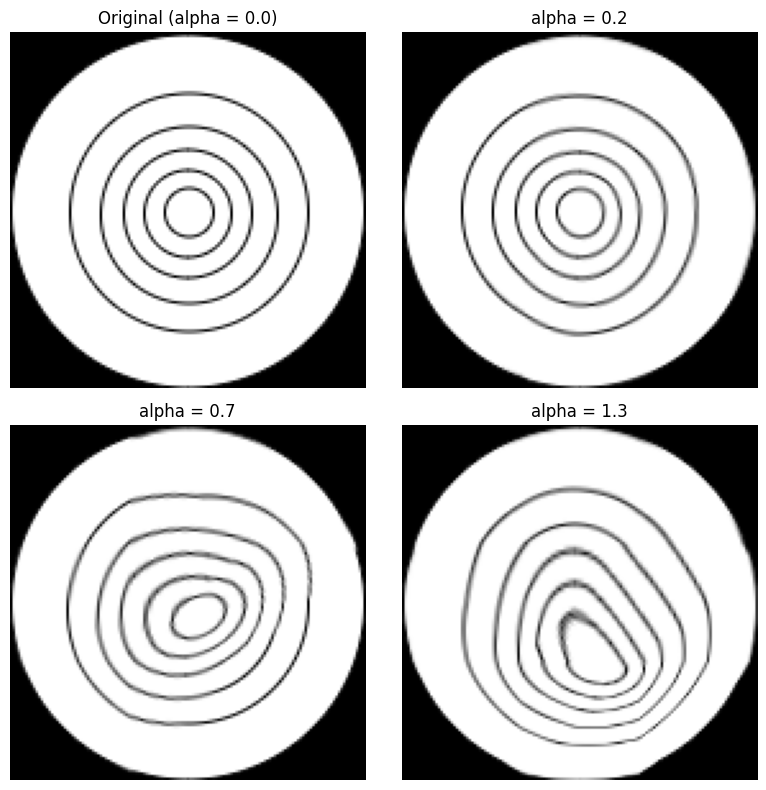

In [26]:
# Transformation demonstrated on a symbolic image

image = cv2.imread('conc_circles.png')

deformed_image_0_2 = execute(image, alpha=0.2)
deformed_image_0_7 = execute(image, alpha=0.7)
deformed_image_1_3 = execute(image, alpha=1.3)


fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].imshow(image)
axs[0, 0].set_title("Original (alpha = 0.0)")
axs[0, 0].axis('off')

axs[0, 1].imshow(deformed_image_0_2)
axs[0, 1].set_title("alpha = 0.2")
axs[0, 1].axis('off')

axs[1, 0].imshow(deformed_image_0_7)
axs[1, 0].set_title("alpha = 0.7")
axs[1, 0].axis('off')

axs[1, 1].imshow(deformed_image_1_3)
axs[1, 1].set_title("alpha = 1.3")
axs[1, 1].axis('off')


plt.tight_layout()


plt.show()


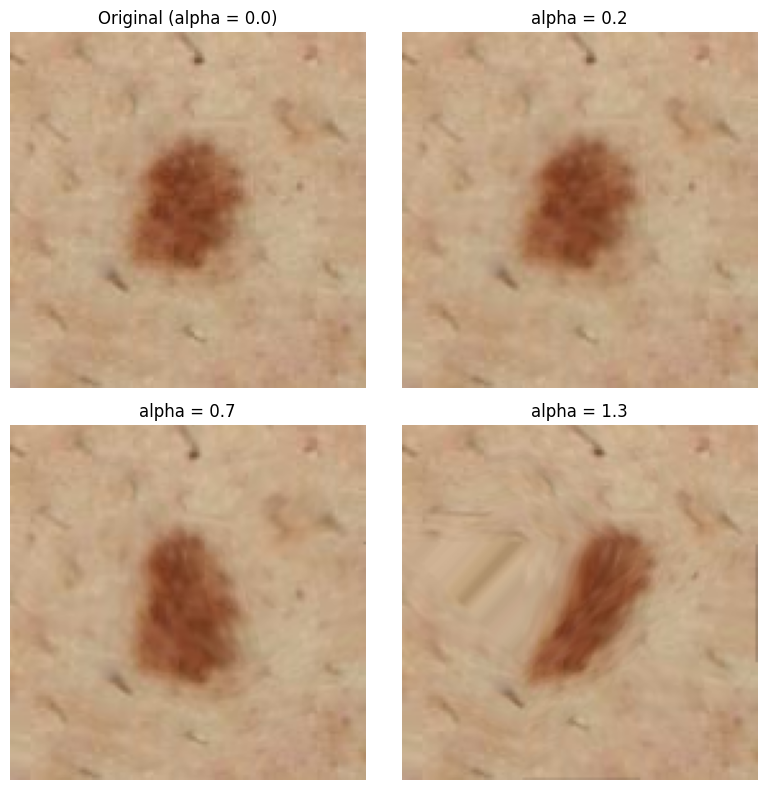

In [27]:
# Transformation demonstrated on a test image

image = cv2.imread('test_im_1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

deformed_image_0_2 = execute(image, alpha=0.2)
deformed_image_0_7 = execute(image, alpha=0.7)
deformed_image_1_3 = execute(image, alpha=1.3)


fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].imshow(image)
axs[0, 0].set_title("Original (alpha = 0.0)")
axs[0, 0].axis('off')

axs[0, 1].imshow(deformed_image_0_2)
axs[0, 1].set_title("alpha = 0.2")
axs[0, 1].axis('off')

axs[1, 0].imshow(deformed_image_0_7)
axs[1, 0].set_title("alpha = 0.7")
axs[1, 0].axis('off')

axs[1, 1].imshow(deformed_image_1_3)
axs[1, 1].set_title("alpha = 1.3")
axs[1, 1].axis('off')


plt.tight_layout()


plt.show()